# Fair Weather pedalers
** Weather's effect on bike share ridership on the Hubway system in Boston and its environs. **  
Kevin Burek &lt;<kburek@fas.harvard.edu>>, Joshua Mclellan &lt;<jvl.mclellan@gmail.com>>  
Harvard AM 207 Spring 2016 Final Project  

## Abstract
The Hubway bicycle share system serves riders in the urban core and near suburbs of Boston.  We'd like to discover something about the riders who use the system.  In 2013, the service providers released a dataset which we will analyze with respect to historical weather data, in order to explore the validity of different modeling hypotheses.  In brief, we believe that ridership may be composed of different constituencies, commuters and joyriders, which are affected differently by varying weather conditions.

## Tools
For analysis, we are using SciPy, NumPy, Pandas, PyMC, and Matplotlib.  
Some other core python libaries are coming along for the ride, too.

In [415]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import dateutil.parser as dtp

import scipy
from scipy import stats
import pandas as pd
import pymc as pm

import re
import numpy as np

import string

In [453]:
sns.set_context("notebook", font_scale=1.25, rc={'figure.figsize':(14,8)})

## Data
The good folks at [Hubway](http://www.thehubway.com/) published the corpus of ridership logs from the system's inception in July 2011 through the end of the cycling season in 2013<sup>[[1]][@hubwaydatachallenge_zip]</sup>. For weather data, we turn to NOAA, whose [National Centers for Environmental Information](https://www.ncdc.noaa.gov/) provides the service of publishing [Climate Data Online](https://www.ncdc.noaa.gov/cdo-web/). We requested and received a data set including daily observed weather conditions for the relevant time period, for the Boston metropolitan area<sup>[[2]][@ncdc_boston]</sup>.


[@hubwaydatachallenge_zip]: http://files.hubwaydatachallenge.org/hubway_2011_07_through_2013_11.zip "Hubway Data Challenge. "hubway_2011_07_through_2013_11". Zip Archive. Retrieved 16 March 2016."

[@ncdc_boston]: http://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/locations/CITY:US250002/detail "NOAA National Centers for Environmental Information. "Daily Summaries Location Details: Boston, MA""

In [343]:
# Set a flag for whether to load the whole data set, or just a portion.
load_all = False
nb_root = ""
# Read ridership data
rides_path = "data/hubway_2011_07_through_2013_11/%shubway_trips.csv"
raw_rides = pd.read_csv(nb_root + rides_path % "") if load_all else pd.read_csv(nb_root + rides_path % "fewer_")
# Read weather data
weather_na = ("unknown", "9999", "-9999")
raw_weather = pd.read_csv(nb_root + "data/ncdc-2013.csv", na_values=weather_na)

raw_weather.head()

,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,DATETIME,PRCP,PRCP Measurement Flag,PRCP Quality Flag,...,TMIN,TMIN Measurement Flag,TMIN Quality Flag,TMIN Source Flag,TMIN Time of Observation,TOBS,TOBS Measurement Flag,TOBS Quality Flag,TOBS Source Flag,TOBS Time of Observation
0,GHCND:USW00054704,NORWOOD MEMORIAL AIRPORT MA US,15.2,42.19083,-71.17361,20100101,2010-01-01T12:00,0,T,,...,-38,,,W,NaN,NaN,,,,NaN
1,GHCND:USW00054704,NORWOOD MEMORIAL AIRPORT MA US,15.2,42.19083,-71.17361,20100102,2010-01-02T12:00,23,,,...,-60,,,W,NaN,NaN,,,,NaN
2,GHCND:USW00054704,NORWOOD MEMORIAL AIRPORT MA US,15.2,42.19083,-71.17361,20100103,2010-01-03T12:00,5,,,...,-93,,,W,NaN,NaN,,,,NaN
3,GHCND:USW00054704,NORWOOD MEMORIAL AIRPORT MA US,15.2,42.19083,-71.17361,20100104,2010-01-04T12:00,0,,,...,-88,,,W,NaN,NaN,,,,NaN
4,GHCND:USW00054704,NORWOOD MEMORIAL AIRPORT MA US,15.2,42.19083,-71.17361,20100105,2010-01-05T12:00,0,,,...,-93,,,W,NaN,NaN,,,,NaN


In [336]:
weather = pd.DataFrame();
weather['STATION'] = raw_weather['STATION']
weather['DATE'] = raw_weather['DATE']
weather.set_index(['STATION', 'DATE'], drop=True, inplace=True)
weather['YEAR'] = [d[0:4] for d in raw_weather['DATE'].astype(np.str_)]
weather['MONTH'] = [d[4:6] for d in raw_weather['DATE'].astype(np.str_)]
weather['DAY'] = [d[6:] for d in raw_weather['DATE'].astype(np.str_)]
weather.head()


YEAR MONTH DAY
STATION           DATE                    
GHCND:USW00054704 20100101  2010    01  01
                  20100102  2010    01  02
                  20100103  2010    01  03
                  20100104  2010    01  04
                  20100105  2010    01  05

## Cleaning
Here we clean the data for analysis.  

### Augmenting ridership data
The ridership data has some properties that aren't well expressed in its current form. We calculate and add columns for the following extracted properties:  
* Start & End day of week (0/Monday - 6/Sunday) 
* Start & End time of day (00:00 - 23:59)
* ... Duration, rider age, ...

Additionally, we pickle the processed data so that we don't have to parse the csv for every new run.

In [337]:
do_rebuild = False
ride_pickle_name = 'rides_pickle'
try:
    if do_rebuild: raise 'abort.';
    rides = pd.read_pickle(ride_pickle_name)
except:
    import dateutil.parser as dtp
    rides = raw_rides.copy()
    totalseconds = lambda t: (t.hour*60 + t.minute)*60 + t.second
    for endpoint in ('start', 'end'):
        %time datetimes = [dtp.parse(d) for d in rides[endpoint + '_date']]
        rides.loc[:,endpoint + '_datetime'] = pd.Series(datetimes, index = rides.index)
        rides.loc[:,endpoint + '_weekday'] = pd.Series([d.weekday() for d in datetimes], index = rides.index)
        rides.loc[:,endpoint + '_seconds'] = pd.Series([totalseconds(d.time()) for d in datetimes], index = rides.index)
    
    rides.to_pickle(ride_pickle_name)




In [338]:
# Create an adjusted start time with the day boundary at 3:30 am.
adj_hrs = 3.5
rides.loc[:,'adj_start_seconds'] = rides['start_seconds'] - adj_hrs * 60 * 60
rides.loc[rides['adj_start_seconds'] < 0,'adj_start_seconds'] += 24 * 60 * 60

### Augmenting weather data
The raw weather data needs measurement flag columns renamed to associate them with the measurement dimensions they describe.  For now, we use pre-processed data.


# Ride data: Departure times

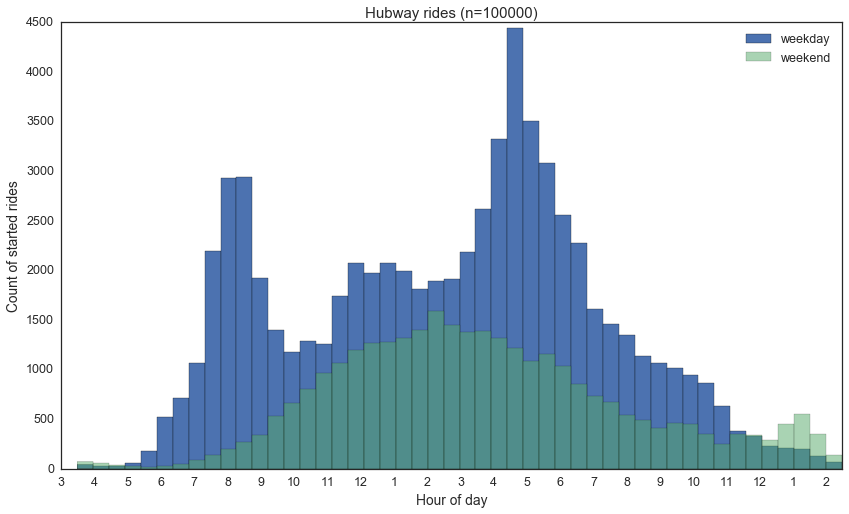

In [347]:
plt.hist(rides.loc[rides['start_weekday'] < 5,'adj_start_seconds'], bins=48, label="weekday")
plt.hist(rides.loc[rides['start_weekday'] >= 5,'adj_start_seconds'], bins=48, label="weekend", alpha=.5)
plt.xlim((0, 24*3600))
plt.xticks(np.linspace(0,24*3600, 24) + (int(adj_hrs) - adj_hrs)*3600)
plt.gca().set_xticklabels((np.arange(int(adj_hrs),int(24+adj_hrs),1) % 12 + 1)[(11,0,1,2,3,4,5,6,7,8,9,10)*2,])
plt.title("Hubway rides (n=%d)" % len(rides))
plt.xlabel("Hour of day")
plt.ylabel("Count of started rides")
plt.legend()
plt.show()

# Formulating the likelihood
To generate a posterior predictive, we will eventually need
$$ P(\Theta | D) = \frac{P(D|\Theta)P(\Theta)}{P(D)} $$
The likelihood is a product over all of our ridership data $R$ and spread across heirarchical model components $L$ for each rental location:
$$ \mathcal{L} = P(D | \Theta) = \prod_R { \sum_L { p\left(t_d, w_d, \omega, s\ |\ \mu_t, \sigma_t, \lambda_d, c\right) } } $$

With data dimensions:  
$t_d$: Time of departure $\in$ $[$0/Midnight $\dots$ 43200/Noon $\dots$ 86400/Midnight$)$  
$w_d$: Weekday of departure $\in$ $\{$0/Monday $\dots$ 6/Sunday$\}$  
$\omega$: Weather quality $\propto {f}($temperature, sunlight, $\dots)$  
$s$: Subscription status $\in$ $\{0,1\}$

With model parameters:  
$\mu_t$: Mean time of departure $\in$ $[$0/Midnight $\dots$ 43200/Noon $\dots$ 86400/Midnight$)$  
$\sigma_t$: Deviation in time of departure $\in$ $[0,\infty)$  
$\lambda_w$: Ratio of weekday departures $\in$ $[0,1)$ such that $\left(\sum_{i=0}^{6}{\lambda_{w_i}}\right) = 1$  
$c$: Rider Commitment $\in$ $\{$0/Joyrider, 1/Morning Commuter, 2/Evening Commuter$\}$  


The full likelihood is a beast.  First, we can write the location-likelihood as a linear function of the fair-weather likelihood:  
$$\mathcal{L}_L = \omega(\mathscr{L}_f) + b + \varepsilon$$
The fair-weather likelihood is mixture of gaussians:  
$$\begin{align}  
\mathcal{L}_f
= & \sum_{c}{w_c\cdot\left(\sum_w{\lambda_w\left(\mathcal{N}\left(t_d\mid\mu_{t_{c}L}, \sigma_{t_{c}}\right)\right)}\right)}
\end{align}$$

[expanded_exponentials]: mathTeX:saved/for/later "(1-c)\cdot\left(\sum_w{\lambda_w\left(exp\left[\frac{-(t_d-\mu_{t_\overline{c}L})^2}{{\sigma_{t_{\overline{c}}}}^2}\right]\right)}\right) + \frac{c}{2}\cdot\left(\sum_w{\lambda_w\left(exp\left[\frac{-(t_d-\mu_{t_{c1}L})^2}{{\sigma_{t_c}}^2}\right] + exp\left[\frac{-(t_d-\mu_{t_{c2}L})^2}{{\sigma_{t_c}}^2}\right]\right)}\right) \\ "

## Labeling commitment on weekday rides

We will use expectation maximization to attempt recovery of the hidden commitment label $c$, which indicates mixture weights $w_c$.  To accomplish this, we introduce a variable, $\lambda_c$ which represents the estimated fraction of the total rides that each commitment label is responsible for.  
For now, we will work with a simplified form of the likelihood, where we don't account for day of week (therefore there are no $\lambda_w$), nor weather (we look at only $\mathcal{L}_f$), and the model is completely pooled (no heirarchy around the location $L$)

The E-step will find the expectation values of the mixure weights, $w_c$.

$$ w_c = \frac{1}{\sum_{c}{w_c}} \sum_{i=0}^{R}{\mathcal{N}\left((t_d)_i\mid (\mu_{t})_c, (\sigma_{t})_{c}\right)p\left(c_i=c\mid\lambda_c\right)}$$

The M-step will maximize the likelihood with respect to the parameters of the mixture components, $\mu_{t_{c}}$ and $\sigma_{t_{c}}$, as well as the label porportions $\lambda_c$.  We will use MLE for the updates.

In [318]:
# Find weights for each w_c given the data and current mixture parameters.
def e_step(data, mus, sigmas, lmbdas):
    """
    Find weights for each w_c given the data and current mixture parameters
    :data: pandas dataframe with 'start_seconds'
    :mu: array of mixture time means.
    :sigma: array of mixture time deviations.
    :return: weights [w_0, w_1, ... w_C] for each item in data.
    """
    td = np.array(data['adj_start_seconds'])  # Time of departure
    non_normal_ws = np.array([stats.norm.pdf(td, mus[i], sigmas[i]) * lmbdas[i] for i in range(len(mus))])
    norm_factor = np.sum(non_normal_ws, axis=0)
    zero_weights = (norm_factor == 0)  # positions where normalization factor is zero
    norm_factor[zero_weights] = 1  # normalization factors that were zero are now set to 1.
    ws = non_normal_ws/norm_factor  # Normalized array of weights.
    ws[:, zero_weights] = 1./np.nan_to_num(np.inf)  # data weights where norm was zero are now nonzero.
    if np.isnan(ws).any():
        print "got nan."
    return ws


# Update mixture parameters given the data and the current mixture weights.
def m_step(data, ws):
    """
    Update mixture parameters given the data and the current mixture weights.
    :param data: pandas dataframe with 'start_seconds'
    :param ws: array of mixture weights.
    :return: hash {'mu', 'sigma', 'lambda'}
    """
    #Update mixture parameters using MLE.
    td = np.array(data['adj_start_seconds'])

    lmbdas = np.mean(ws, axis=1)
    mus = np.array([np.sum(td*w)/np.sum(w) for w in ws])
    sigs = np.sqrt(np.array([np.sum(ws[j]*(td-mus[j])*(td-mus[j]))/np.sum(ws[j]) for j in range(len(mus))]))
    if np.isnan(sigs).any():
        print "got nan."

    return {'mu': mus, 'sigma': sigs, 'lambda': lmbdas}


In [319]:
doPrint = False
def fit_gaussians(rides, num_gaussians=3, init_parms = None):
    tol = .0001 # Convergence tolerance
    # Guess some parameters to get us started.
    parms = init_parms
    if init_parms is None:
        parms = {}
        parms['mu'] = np.zeros((num_gaussians))
        parms['sigma'] = np.zeros((num_gaussians,))
        parms['lambda'] = np.zeros((num_gaussians,))
    else:
        parms['mu'] = np.r_[parms['mu'][:num_gaussians], np.zeros(np.max((num_gaussians - len(parms['mu']),0)))]
        parms['sigma'] = np.r_[parms['sigma'][:num_gaussians], np.zeros(np.max((num_gaussians - len(parms['sigma']),0)))]
        parms['lambda'] = np.r_[parms['lambda'][:num_gaussians], np.zeros(np.max((num_gaussians - len(parms['lambda']),0)))]

    parms['mu'][parms['mu'] == 0] = np.linspace(0, 86400, num_gaussians + 2)[1:-1][parms['mu'] == 0]
    parms['sigma'][parms['sigma'] == 0] = (np.zeros((num_gaussians,)) + 600)[parms['sigma'] == 0]
    parms['lambda'][parms['lambda'] == 0] = (np.zeros((num_gaussians,)) + 1.)[parms['lambda'] == 0]
    weights = e_step(rides, parms['mu'], parms['sigma'], parms['lambda'])

    # Run E-M iteration until the weights don't change, or we lose patience.
    itr = 0
    converged = False
    while not converged:
        itr += 1
        old_weights = weights
        old_parms = parms
        parms = m_step(rides, weights)
        if doPrint and itr % 100 == 0:
            print 'Model parameters: %s' % str(parms)
        weights = e_step(rides, parms['mu'], parms['sigma'], parms['lambda'])
        if doPrint and itr % 100 == 0:
            print 'Weights: %s' % str(weights)
        weight_change = np.sum(np.abs(weights - old_weights))
        mu_changes = np.abs(old_parms['mu'] - parms['mu'])
        sig_changes = np.abs(old_parms['sigma'] - parms['sigma'])
        lam_changes = np.abs(old_parms['lambda'] - parms['lambda'])
        converged = (weight_change < tol
                     and np.sum(mu_changes) < tol
                     and np.sum(sig_changes) < tol
                     and np.sum(lam_changes) < tol)
        if itr > 10000:
            print "Incomplete!"
            break
    parms['wcs'] = weights
    return parms

In [320]:
parms = fit_gaussians(rides)

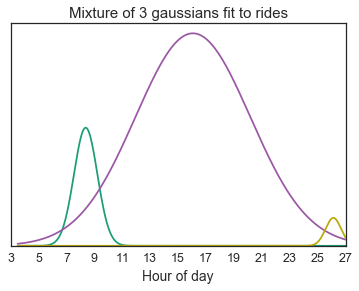

In [380]:
# Plot the mixture of gaussians we just fit.
def plot_mixture(parms, setSize = True):
    if setSize:
        plt.gcf().set_size_inches(6,4)
    n_gaussians = len(parms['mu'])
    x = np.linspace(0,60*60*24, num=100000)
    x_hr = (x + adj_hrs * 3600) / (60*60)  # x value in hours
    plt.title("Mixture of %d gaussians fit to rides" % (n_gaussians))
    cmap = plt.get_cmap('Dark2')
    for i in range(n_gaussians):
        ii = float(i) / n_gaussians
        plt.plot(x_hr, stats.norm.pdf(x, parms['mu'][i], parms['sigma'][i])*parms['lambda'][i], color=cmap(ii))
    plt.xlabel("Hour of day")
    plt.xticks(np.arange(0,27,2)+int(adj_hrs))
    plt.yticks(())
    plt.xlim(3,27)
    #plt.legend()
plot_mixture(parms)

Well that's not what we expected.  Those weekend bar-flies hijacked our joyrider's distribution.  
Let's try just weekdays.

In [327]:
wparms = fit_gaussians(rides[rides['start_weekday'] < 5], 3)

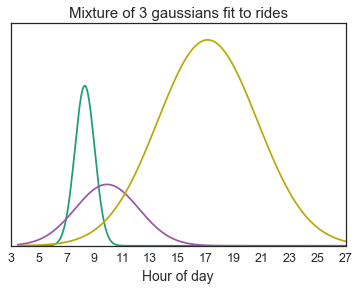

In [381]:
plot_mixture(wparms)

Well that doesn't look like our hypothesis either.  Let's try with a guess with initial conditions that strongly look like our hypothesis.

In [358]:
strong_guess_parms = {}
strong_guess_parms['mu'] = np.array([(14 - adj_hrs)* 60 * 60, (8 - adj_hrs) * 60 * 60, (17 - adj_hrs) * 60 * 60])
strong_guess_parms['sigma'] = np.array([3 * 60 * 60, 1 * 60 * 60, 1 * 60 * 60])
strong_guess_parms['lambda'] = np.array([1, 1, 1])
fit_parms = fit_gaussians(rides[rides['start_weekday'] < 5], init_parms = strong_guess_parms.copy())

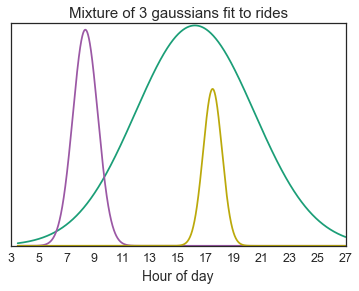

In [382]:
plot_mixture(fit_parms)

OK, that's what we wanted.  It's not a good sign that we had to influence the model with such a specific guess.

## Experimenting with other numbers of gaussians
Let's compare the goodness of fit using the posterior predictive, vs. models with 1 through 6 gaussians.

In [362]:
n_fits = 6
n_fit_parms = np.empty(n_fits, dtype=object)
for n in range(n_fits):
    n_fit_parms[n] = fit_gaussians(rides[rides['start_weekday'] < 5], n+1, init_parms = strong_guess_parms.copy())    

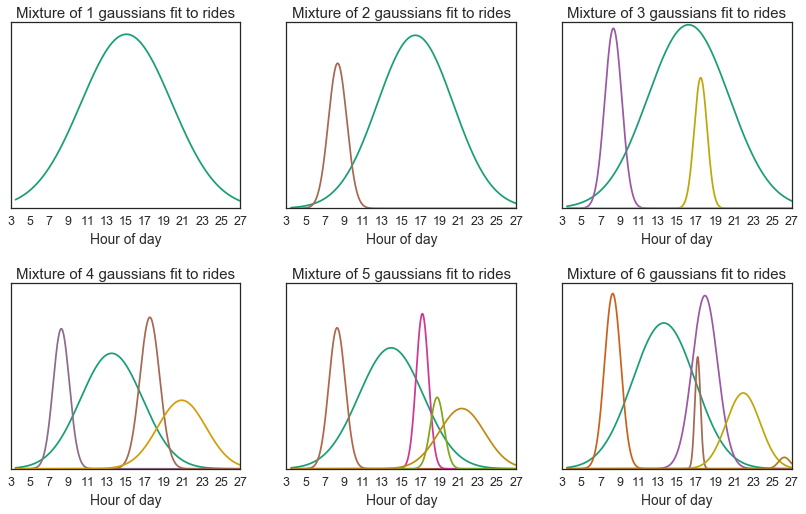

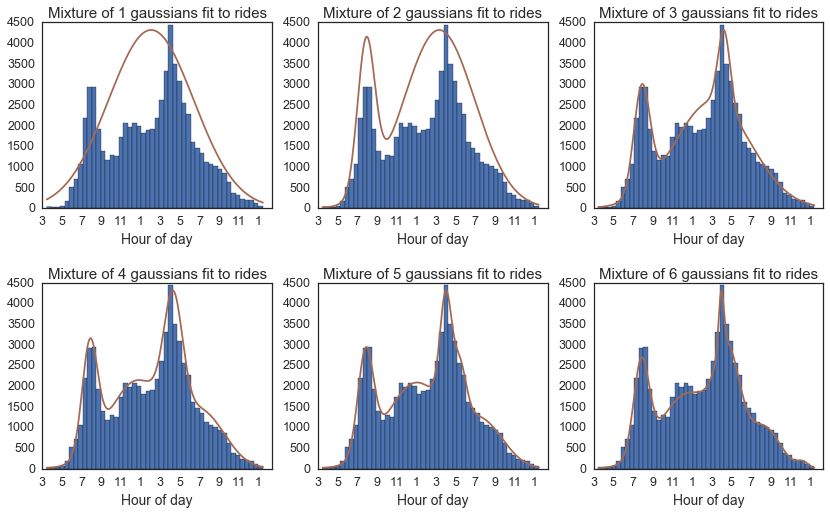

In [457]:
plt.gcf().subplots_adjust(hspace=.4)
for n in range(6):
    plt.subplot(2,3,n+1)
    plot_mixture(n_fit_parms[n], setSize=False)
plt.show()

def plot_sum(parms, ypeak = None):
    n_gaussians = len(parms['mu'])
    x = np.linspace(0,60*60*24, num=100000)
    x_hr = (x + adj_hrs * 3600) / (60*60)  # x value in hours
    plt.title("Mixture of %d gaussians fit to rides" % (n_gaussians))
    cmap = plt.get_cmap('Dark2')
    y = np.zeros(x.shape)
    for i in range(n_gaussians):
        y += stats.norm.pdf(x, parms['mu'][i], parms['sigma'][i])*parms['lambda'][i]
    yscale = 1 if ypeak is None else ypeak/np.max(y)
    plt.plot(x, y * yscale, color=cmap(.5))
    plt.xticks(np.linspace(0,24*3600, 12) + (int(adj_hrs) - adj_hrs)*3600)
    plt.gca().set_xticklabels((np.arange(int(adj_hrs),int(24+adj_hrs),1) % 12 + 1)[((11,0,1,2,3,4,5,6,7,8,9,10)*2)[::2],])
    plt.xlabel("Hour of day")
    #plt.xlim(3,27)
    #plt.legend()

plt.gcf().subplots_adjust(hspace=.4)
for n in range(6):
    plt.subplot(2,3,n+1)
    peak = np.max(np.histogram(rides.loc[rides['start_weekday'] < 5,'adj_start_seconds'], bins=48)[1])
    plt.hist(rides.loc[rides['start_weekday'] < 5,'adj_start_seconds'], bins=48, label="weekday")
    plot_sum(n_fit_parms[n], ypeak = peak/20)
plt.show()

### Comparing goodness of fit using AIC(WAIC)
The Akaike Information Criterion (alternatively called Watanabe-Akaike Information Criterion or widely applicable information criterion<sup>[[1]][@loo_stan]</sup>), gives an estimate of information loss in each model, by relating <font color="red">maximum?</font> likelihood to the 'estimated' number of parameters in the model (as calculated with the variance of the pointwise likelihood values).  The AIC values for the different models can then be compared to each other.  The best model will have the lowest AIC, and the other models' relative fitness can be measured accordingly.


[@loo_stan]: http://www.stat.columbia.edu/~gelman/research/unpublished/loo_stan.pdf "A. Gelman, A. Vehtari, J. Gabry; \"Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC\""

AIC for n=1: 22.6943
AIC for n=2: 22.0011
AIC for n=3: 21.8880
AIC for n=4: 20.7419
AIC for n=5: 20.6119
AIC for n=6: 20.5097
Deviations from minimum AIC:[ 0.33545008  0.47440442  0.50200522  0.89038058  0.95017432  1.        ]


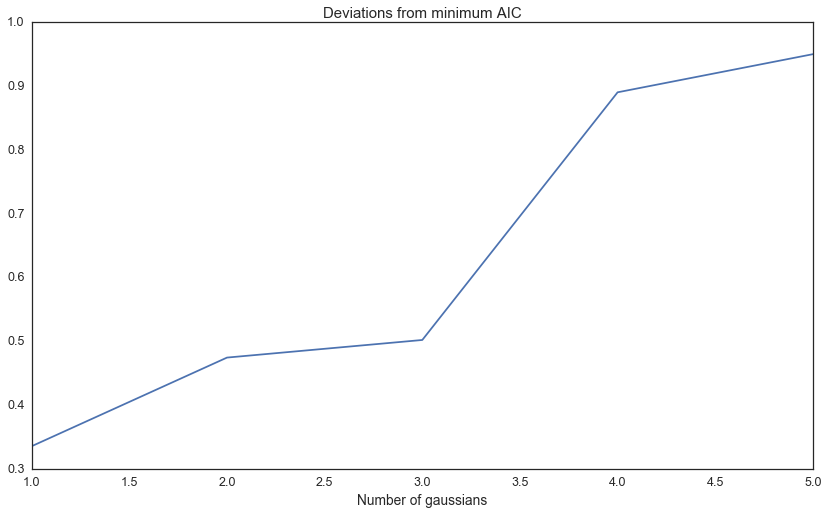

In [456]:
# Testing goodness of fit with AIC. https://en.wikipedia.org/wiki/Akaike_information_criterion
n_fits = 6
like_vals = np.zeros(n_fits)
log_likes = np.empty(n_fits, dtype=object)
aics = np.zeros(n_fits)
for n in range(n_fits):
    td = rides.loc[rides['start_weekday'] < 5, 'adj_start_seconds']
    p = n_fit_parms[n]
    c_log_likes = np.array([np.log(p['wcs'][c]) + stats.norm.logpdf(td, p['mu'][c], p['sigma'][c]) for c in range(len(p['mu']))])
    log_likes[n] = scipy.misc.logsumexp(c_log_likes, axis=0)
    # Calculating AIC 
    #  As compared to cross-validation: http://www.stat.columbia.edu/~gelman/research/unpublished/loo_stan.pdf
    #  In python, for pymc3: https://github.com/pymc-devs/pymc3/issues/888
    aic_est_parm_n = np.sum(np.var(log_likes[n]), axis=0)
    lppd =  np.sum(np.log(np.mean(np.exp(log_likes[n]), axis=0)))
    aics[n] = 2 * aic_est_parm_n - 2 * lppd
    print "AIC for n=%d: %0.04f" % (n+1, aics[n])
    
aic_min_i = np.argmin(aics)
aic_min = aics[aic_min_i]
aic_notmin = np.ones_like(aics, dtype = bool)
aic_notmin[aic_min_i] = False
print "Deviations from minimum AIC:" + str(np.exp((aic_min - aics)/2))
plt.title("Deviations from minimum AIC")
plt.xlabel("Number of gaussians")
plt.plot((np.arange(n_fits)+1)[aic_notmin], np.exp((aic_min - aics[aic_notmin])/2))

Apparently the single-gaussian model is the best one?  I'm not willing to accept that.  Maybe there's a bug here.  Maybe I'll get something more sensible by looking at the evidence or posterior predictive.

# Next steps

### Building a heirarchical model
We will use separate lambdas and mus per station, but use common hyperparameters to tie the stations together.  In addition, the variances will be shared across the system.


### Incorporating weather data
I would bet that the m-step won't be able to just use an MLE, because we no longer have a conjugate model.  We could use simulated annealing?  I've experimentd with this already (see prototyping/sa_em.py, prototyping/mix_model.py, prototyping/simulated_annealer.py).  I'd like to know if I can speed up SA, because it seems to take hundreds of thousands of iterations of SA to accomplish one m-step.  Also, the simulated annealer needs a lot of tweaking when the energy function blows up because of the hugely negative log likelihood that occurs when you add together log likelihoods for around a million data points.

Maybe we can model the joyriders as a gamma?  
$ \frac{\partial}{\partial\alpha} \text{Gamma}\left(x\mid\alpha,\beta\right) = $
(d)/(da)((b^a x^(a-1) e^(-x b))/(Gamma(a))) = (b^a x^(a-1) e^(-b x) (-polygamma(0, a)+log(b)+log(x)))/(Gamma(a))

$ \frac{\partial}{\partial\beta} \text{Gamma}\left(x\mid\alpha,\beta\right) = $
(d)/(db)((b^a x^(a-1) e^(-x b))/(Gamma(a))) = (b^(a-1) x^(a-1) e^(-b x) (a-b x))/(Gamma(a))


[@wolfram_1]: https://www.wolframalpha.com/input/?i=d%2Fda+(b%5Ea+*+x%5E(a-1)+*+e%5E(-x*b))%2F(Gamma(a)) "Wolfram alpha"

## Investigating other properties of the data
Here we look at a histogram of rider ages.

(array([  74,  179,  329,  805, 1235, 1081, 1316, 1768, 2576, 2258, 1942,
       2641, 2038, 2105, 2028, 1558, 1374, 1728, 1382, 1478, 1381, 1262,
        946,  900, 1408,  833,  953,  881, 1318,  793,  580,  819, 1016,
        521,  718,  758,  564,  777,  527,  405,  293,  457,  282,  189,
        286,  181,  150,  202,  114,  125,   41,   23,   54,    5,   27,
         14,   13,    0,    0,    0,    0,    5], dtype=int64), array([ 17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,
        28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,
        39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,
        50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,
        61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
        72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.]))


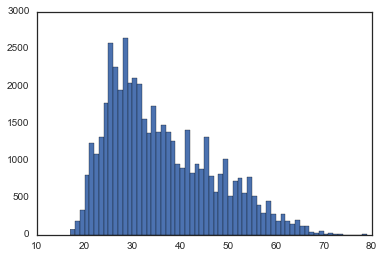

In [79]:
rides = rides.dropna()
ages = [d.year for d in rides['start_datetime']] - rides['birth_date']

nbins = np.max(ages) - np.min(ages)
print np.histogram(ages, bins=nbins)
plt.hist(ages, bins=nbins)
plt.show()
